<a href="https://colab.research.google.com/github/Kamil11-del/yolo-v8s-daily-object-detection/blob/main/object_detection_usingYOLO8s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING DATASET FROM KAGGLE

In [ ]:
!pip install kaggle

## Download Kaggle Dataset in Google Colab

To download a Kaggle dataset in Google Colab, you need to upload your Kaggle API key as a JSON file and follow these steps.

### Step 1: Upload Your Kaggle API Key

First, make sure you have downloaded your Kaggle API key (`kaggle.json`) from your Kaggle account. You can get this from your [Kaggle account settings](https://www.kaggle.com/account).

In Colab, upload this file by running the following code:

```python
from google.colab import files
files.upload()  # Upload the 'kaggle.json' file here


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammmadkamilkhan","key":"fe42d2ed246a99b2cc321ccd69dc59b6"}'}

## Step 2: Configure Kaggle API in Colab
After uploading the kaggle.json file, you need to set the appropriate permissions and configure it so you can access the Kaggle API:

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


## Step 3: Download and Unzip the Dataset
Now, you can download any dataset from Kaggle using the Kaggle CLI. In this case, to download the Dollar Street dataset, run the following commands:

In [ ]:
!kaggle datasets download -d humansintheloop/dollar-street-dataset

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/dollar-street-dataset
License(s): CC0-1.0
100% 3.26G/3.27G [00:37<00:00, 32.1MB/s]
100% 3.27G/3.27G [00:37<00:00, 92.6MB/s]


In [ ]:
!unzip dollar-street-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dollar street trial/Places__parking-lots/img/a9f1137b1d5b3796fb2850078e9479bf37fcdd2d.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/aa8d50c4cfd60a48fe28439b3f51f5dd5d7bd49c.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/ab3e6e2a8fe8a9bb23a829fd79f8afad5bca58a8.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/acb140803e5a7fbbe5e7714e489ae473fbf02a7a.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/adc3a84c34b351c2de0b7f20eecddfa762d91443.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/b38e1c42756819d731f12968d8a4854f9798395f.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/b4c4796fc162bf2873e0135b0e5ed8ae27d4f648.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/b6ead3b405df76fb8cfe69aeaa6c1e0c9524b0bb.jpg  
  inflating: Dollar street trial/Places__parking-lots/img/b7a8f4940ef82f86724b6e207344c2d7d46808ca.jpg  
  in

# INSTALL NECCESSARY LIBRARIES

In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 13.5 MB/s eta 0:00:00


In [2]:
# Step 1: Load and prepare the data
import os
import shutil
import json
import glob
import random
import cv2
import numpy as np
import yaml
from sklearn.model_selection import train_test_split
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# iNITIALIZING PATHS TO ABSOLUTE DATASET

In [ ]:
#paths
input_base_dir = '/content/Dollar street trial'
output_base_dir = '/content/output'
output_ann_dir = '/content/output/annotations'
meta_json_path = os.path.join(input_base_dir, 'meta.json')
# Ensure output directories exist
os.makedirs(output_ann_dir, exist_ok=True)

In [ ]:
# Load class mappings from meta.json
with open(meta_json_path, 'r') as f:
    meta_data = json.load(f)
class_mapping = {cls['title']: i for i, cls in enumerate(meta_data['classes'])}

# CONVERTING JSON TO YOLO FORMAT:

This code converts object detection annotations from JSON format to YOLO format. It is designed to process annotations stored in subdirectories and generate corresponding YOLO annotation files. Here's a breakdown of its purpose:

1. **Bounding Box Conversion:**

Converts bounding box coordinates from JSON format (using exterior points) to YOLO format (center x, center y, width, height) relative to the image size.

2. **Directory Processing:**

Traverses through directories, each containing annotation (ann) and image (img) subdirectories.

3. **JSON to YOLO Annotation Conversion:**

Reads JSON annotation files, extracts object classes and bounding boxes, and converts them into the YOLO format.

4. **File Handling:**

Creates corresponding .txt files for each annotation, ensuring the correct YOLO format is written and the output directory structure mirrors the input.

5. **Class Mapping:**

Uses a predefined mapping (class_mapping) to assign a class ID for each object in the JSON annotations.

In [ ]:
# Convert bounding boxes from JSON to YOLO format
def convert_bbox_to_yolo(points, img_width, img_height):
    x_min, y_min = points[0]
    x_max, y_max = points[1]
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return x_center, y_center, width, height

# Convert JSON annotations to YOLO format and save them
def convert_json_to_yolo(json_path, output_txt_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    img_width = data['size']['width']
    img_height = data['size']['height']
    yolo_annotations = []
    for obj in data['objects']:
        class_id = class_mapping.get(obj['classTitle'])
        if class_id is None:
            continue
        points = obj['points']['exterior']
        x_center, y_center, width, height = convert_bbox_to_yolo(points, img_width, img_height)
        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Write YOLO annotations to the output file
    with open(output_txt_path, 'w') as f:
        for ann in yolo_annotations:
            f.write(ann + '\n')

In [ ]:
# Process directories and convert annotations to YOLO format
for directory in os.listdir(input_base_dir):
    dir_path = os.path.join(input_base_dir, directory)
    if os.path.isfile(dir_path):
        continue
    ann_folder = os.path.join(dir_path, 'ann')
    img_folder = os.path.join(dir_path, 'img')
    if not os.path.exists(ann_folder) or not os.path.exists(img_folder):
        continue
    for ann_file in os.listdir(ann_folder):
        ann_path = os.path.join(ann_folder, ann_file)

        # Generate the output file path by removing the .jpg extension from the ann_file before appending .txt
        output_txt_path = os.path.join(output_ann_dir, directory, os.path.splitext(ann_file)[0].replace('.jpg', '') + '.txt')

        os.makedirs(os.path.dirname(output_txt_path), exist_ok=True)
        convert_json_to_yolo(ann_path, output_txt_path)

print("Annotations converted to YOLO format.")

Annotations converted to YOLO format.


## CHECK EXISTENCE OF .TXT FILES

In [ ]:
# Check if the annotations directory exists
if os.path.exists(output_ann_dir):
    # List all subdirectories in the annotations directory
    subdirectories = [d for d in os.listdir(output_ann_dir) if os.path.isdir(os.path.join(output_ann_dir, d))]

    print(f"Total subdirectories found in the annotations folder: {len(subdirectories)}")
    print("Sample of subdirectory names:")
    print(subdirectories[:10])  # Print first 10 subdirectory names as a sample
else:
    print(f"Directory '{output_ann_dir}' does not exist.")


Total subdirectories found in the annotations folder: 138
Sample of subdirectory names:
['Objects__rugs', 'Places__walls-inside', 'Objects__beds', 'Places__parking-lots', 'Objects__radios', 'Objects__spices', 'Abstract__street-details', 'Objects__computers', 'Objects__refrigerators', 'Places__play-areas']


# INITIALIZING OUTPUT PATHS

These are the paths for the output directory, in my case i used kaggle notebook in which we have to initialize paths for the output.

In [ ]:
# Step 2: Train/Val Split and Data Organization
output_train_images_dir = os.path.join(output_base_dir, 'train/images')
output_train_labels_dir = os.path.join(output_base_dir, 'train/labels')
output_val_images_dir = os.path.join(output_base_dir, 'val/images')
output_val_labels_dir = os.path.join(output_base_dir, 'val/labels')

os.makedirs(output_train_images_dir, exist_ok=True)
os.makedirs(output_train_labels_dir, exist_ok=True)
os.makedirs(output_val_images_dir, exist_ok=True)
os.makedirs(output_val_labels_dir, exist_ok=True)

# COPY IMAGES AND LABELS TO ORGANIZED STRUCTURE:

This code performs a train/validation split on a dataset of images and their corresponding annotations, ensuring that both images and annotations are copied into separate folders for training and validation. Here's a breakdown of the process:

### Function Overview

The `copy_image_and_annotation` function is designed to:
- Copy an image file from the source directory to the destination directory.
- Look for the corresponding annotation file (in YOLO format) by matching the image filename (minus the `.jpg` extension) and copying it to the appropriate directory.
- If no annotation is found, the copied image is deleted to ensure only images with annotations are used.

```python
def copy_image_and_annotation(img_file, img_src_folder, ann_src_folder, img_dest_folder, ann_dest_folder):
    # Copies the image and corresponding annotation file to the destination folder.
    # If the annotation file doesn't exist, the image is skipped and removed from the destination.

In [ ]:
# Function to copy image and corresponding annotation
def copy_image_and_annotation(img_file, img_src_folder, ann_src_folder, img_dest_folder, ann_dest_folder):
    # Copy the image file
    src_img_path = os.path.join(img_src_folder, img_file)
    dest_img_path = os.path.join(img_dest_folder, img_file)
    shutil.copy2(src_img_path, dest_img_path)

    # Remove the '.jpg' extension from the image filename to find the corresponding annotation
    ann_file = os.path.splitext(img_file)[0] + '.txt'
    print(f"Looking for annotation file: {ann_file}")

    ann_subdir = ann_src_folder.split('/')[-1]  # Extract subdirectory name
    src_ann_path = os.path.join(output_ann_dir, ann_subdir, ann_file)

    if os.path.exists(src_ann_path):
        print(f"Found annotation for {img_file}: {ann_file}")
        dest_ann_path = os.path.join(ann_dest_folder, ann_file)
        shutil.copy2(src_ann_path, dest_ann_path)
    else:
        print(f"Warning: No annotation found for {img_file}. Skipping this image.")
        # Optionally, delete the image file if there is no annotation
        os.remove(dest_img_path)  # This will remove the copied image without labels

# Perform Train/Validation split
val_ratio = 0.2  # 20% validation


In [ ]:
for sub_dir in os.listdir(input_base_dir):
    img_folder = os.path.join(input_base_dir, sub_dir, 'img')  # Path to images
    ann_folder = os.path.join(output_ann_dir, sub_dir)  # Path to corresponding annotation subdirectory

    if os.path.isdir(img_folder):  # Check if this subdirectory contains images
        img_files = os.listdir(img_folder)
        random.shuffle(img_files)
        split_index = int(len(img_files) * (1 - val_ratio))
        train_files = img_files[:split_index]
        val_files = img_files[split_index:]

        # Process training files
        for img_file in train_files:
            copy_image_and_annotation(img_file, img_folder, ann_folder, output_train_images_dir, output_train_labels_dir)

        # Process validation files
        for img_file in val_files:
            copy_image_and_annotation(img_file, img_folder, ann_folder, output_val_images_dir, output_val_labels_dir)

print("Train/Val split completed.")

Streaming output truncated to the last 5000 lines.
Found annotation for 2cc8ca3bad50aed35f5afdac8697f410c705c504.jpg: 2cc8ca3bad50aed35f5afdac8697f410c705c504.txt
Looking for annotation file: a89323e5e4124c0ea27b2ac46e645e7c27d54c3e.txt
Found annotation for a89323e5e4124c0ea27b2ac46e645e7c27d54c3e.jpg: a89323e5e4124c0ea27b2ac46e645e7c27d54c3e.txt
Looking for annotation file: 5c4ab177e2193332989746b3de4af0e6444d6bcf.txt
Found annotation for 5c4ab177e2193332989746b3de4af0e6444d6bcf.jpg: 5c4ab177e2193332989746b3de4af0e6444d6bcf.txt
Looking for annotation file: c56c405e0cece9f60a2e0d3a94f303172fb4b61f.txt
Found annotation for c56c405e0cece9f60a2e0d3a94f303172fb4b61f.jpg: c56c405e0cece9f60a2e0d3a94f303172fb4b61f.txt
Looking for annotation file: 7b48655f947cf2c5a85c46ff78dc604260dfc8ed.txt
Found annotation for 7b48655f947cf2c5a85c46ff78dc604260dfc8ed.jpg: 7b48655f947cf2c5a85c46ff78dc604260dfc8ed.txt
Looking for annotation file: 94954a7e0fdd73957d30440542435521d2a8fd96.txt
Found annotation fo

## Show the length of both labels/images for confirmation

In [ ]:
def count_images_in_directory(directory):
    # List all files in the directory and filter by image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # Add more extensions if needed
    img_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return len(img_files)
# Count the number of images in each directory
num_train_images = count_images_in_directory(output_train_images_dir)
num_val_images = count_images_in_directory(output_val_images_dir)

# Print the results
print(f"Number of images in the train folder: {num_train_images}")
print(f"Number of images in the validation folder: {num_val_images}")

Number of images in the train folder: 20744
Number of images in the validation folder: 5485


In [ ]:
def check_labels(train_labels_dir, val_labels_dir):
    train_label_files = os.listdir(train_labels_dir)
    val_label_files = os.listdir(val_labels_dir)

    if len(train_label_files) == 0:
        print("Warning: No labels found in the training labels directory.")
    else:
        print(f"Training labels found: {len(train_label_files)}")

    if len(val_label_files) == 0:
        print("Warning: No labels found in the validation labels directory.")
    else:
        print(f"Validation labels found: {len(val_label_files)}")

check_labels(output_train_labels_dir, output_val_labels_dir)

Training labels found: 20744
Validation labels found: 5485


# CREATE YAML FOR MODEL

In [ ]:
# Step 3: Create YAML for YOLOv8
yaml_output_path = os.path.join(output_base_dir, 'data.yaml')
class_names = [cls['title'] for cls in meta_data['classes']]

yaml_data = {
    'train': output_train_images_dir,
    'val': output_val_images_dir,
    'nc': len(class_names),
    'names': class_names
}

with open(yaml_output_path, 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file)

print(f"YAML file created at: {yaml_output_path}")

YAML file created at: /content/output/data.yaml


# TRAIN MODEL

In [ ]:
# Load a YOLO model (YOLOv8s or YOLOv8m depending on preference)
model = YOLO('yolov8s.pt')  # You can switch to 'yolov8m.pt' for medium model

# Train the model on your dataset
results = model.train(
    data='/content/output/data.yaml',  # Path to your dataset YAML file
    epochs=50,                      # Number of training epochs
    batch=16,                       # Adjust batch size according to your GPU memory
    imgsz=640,                      # Image size for training (can adjust between 416-640)
    device=0,                       # Use GPU (0) or CPU (-1)
    lr0 = 0.001,
)

# LOAD THE MODEL:
load when you don't want to run the whole model again but just use trained weights to predict on new unseen data.

In [4]:
# Specify the path to your model weights
model_path = '/content/obj_detect_model_weights.pt'  # Change this to the actual path

# Load the YOLOv8 model
model = YOLO(model_path)

# Optional: Check the model summary
model.info()

Model summary: 249 layers, 9,875,338 parameters, 0 gradients, 23.8 GFLOPs


(249, 9875338, 0, 23.7741568)

# PREDICT AND VISUALIZE

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to predict and visualize the bounding boxes
def predict_and_visualize(image_path, model):
    # Perform inference on the image
    results = model.predict(source=image_path, save=False, conf=0.25)  # You can adjust the confidence threshold

    # Get the image and boxes
    img = Image.open(image_path)
    plt.imshow(img)

    # Extracting predictions from the results object
    predictions = results[0].boxes
    boxes = predictions.xyxy.cpu().numpy()  # bounding boxes in xyxy format
    classes = predictions.cls.cpu().numpy()  # class IDs
    scores = predictions.conf.cpu().numpy()  # confidence scores

    # Plot the bounding boxes on the image
    for box, cls, score in zip(boxes, classes, scores):
        # Unpack box coordinates
        x1, y1, x2, y2 = box
        label = model.names[int(cls)]
        color = 'red'  # Customize the box color
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2))
        plt.text(x1, y1, f'{label} {score:.2f}', color='white', fontsize=12, weight='bold',
                 bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()




image 1/1 /content/test2.jpeg: 352x640 1 Sofa, 649.2ms
Speed: 4.9ms preprocess, 649.2ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


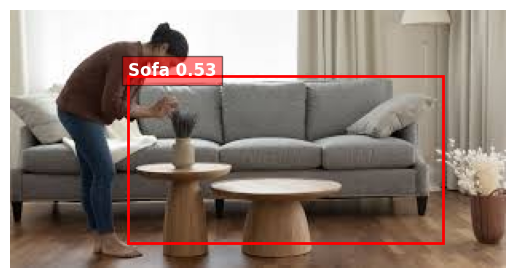

In [10]:
new_image_path2 = '/content/test2.jpeg'
predict_and_visualize(new_image_path2, model)


image 1/1 /content/test3.jpeg: 448x640 (no detections), 652.1ms
Speed: 6.1ms preprocess, 652.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


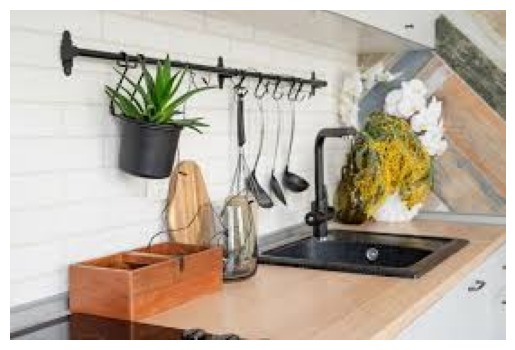

In [12]:
new_image_path3 = '/content/test3.jpeg'
predict_and_visualize(new_image_path3, model)


image 1/1 /content/test4.jpg: 480x640 1 Toothbrush, 435.6ms
Speed: 3.3ms preprocess, 435.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


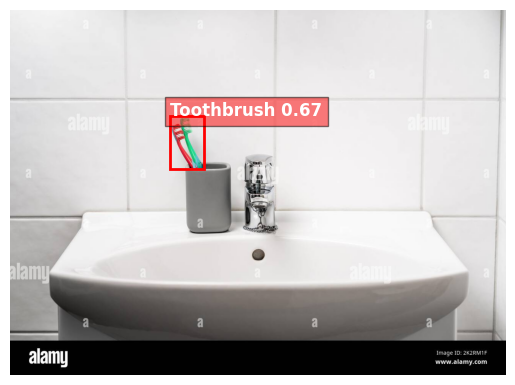

In [13]:
new_image_path4 = '/content/test4.jpg'
predict_and_visualize(new_image_path4, model)


image 1/1 /content/test5.jpg: 640x448 (no detections), 425.2ms
Speed: 4.4ms preprocess, 425.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


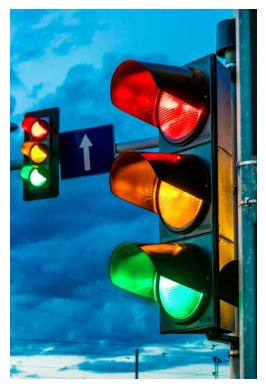

In [14]:
new_image_path5 = '/content/test5.jpg'
predict_and_visualize(new_image_path5, model)


image 1/1 /content/test6.jpeg: 640x480 1 Car, 1 Front door, 453.9ms
Speed: 7.4ms preprocess, 453.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


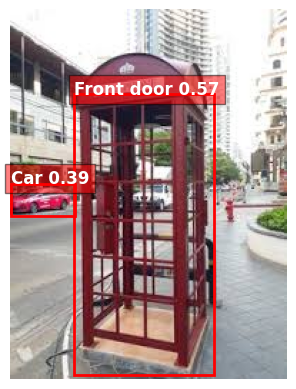

In [16]:
new_image_path6 = '/content/test6.jpeg'
predict_and_visualize(new_image_path6, model)